# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png)

##  Project Capstone

### Reducing Electricity Costs in Romania: Predictive and Reinforcement Learning for Solar Power Optimization

---

[README](../README.md) | [Part 1: Cleaning](01_Cleaning.ipynb) | [Part 2: EDA](02_EDA.ipynb) | [Part 3: Solar Energy Prediction Models](03_Model_Solar_Energy.ipynb) | [Part 4: Electricity Cost Prediction Models](04_Model_Electricity_Cost.ipynb) | **Part 5: Electricity Cost Prediction Using Time Series Models**

---

### Introduction
- In this section, time series models will be developed to predict electricity cost.

### Import and Preprocessing

#### Essential Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pickle

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

#!pip install prophet
from prophet import Prophet
np.random.seed(42)

#### Import Data

In [2]:
df = pd.read_csv('../data/cleaned/electricity_romania.csv')       # Import
df['datetime'] = pd.to_datetime(df['datetime'])                   # Formatting `datetime`
df.set_index('datetime', inplace = True)                          # Set index

In [3]:
df.columns

Index(['temp', 'feelslike', 'dew', 'humidity', 'windgust', 'windspeed',
       'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'has_snow',
       'has_solarradiation', 'icon_cloudy', 'icon_fog', 'icon_partly_cloudy',
       'icon_rain', 'icon_snow', 'ckwh', 'consumption', 'production',
       'nuclear', 'wind', 'hydroelectric', 'oil_gas', 'coal', 'solar',
       'biomass'],
      dtype='object')

In [4]:
df = df[['ckwh']]

In [5]:
df.head()

,ckwh
datetime,
2024-01-01 00:00:00,1.07
2024-01-01 01:00:00,1.50
2024-01-01 02:00:00,0.00
2024-01-01 03:00:00,0.00
2024-01-01 04:00:00,0.00


#### Preprocess

In [6]:
# Add day of weeks, months
df['dow'] = df.index.dayofweek
df['dow'] = df['dow'].apply(lambda x: 1 if x >= 5 else 0)   # 1 if Saturday or Sunday

#### Stationarity
- The Augmented Dickey-Fuller (ADF) test was conducted to assess the stationarity of the data.
- The test yielded p-value of 0.0001, indicating that the data is stationary at a 5% significanat level.
- As the data is already stationary, no further differencing is required.

In [7]:
# Check Stationary using ADF Test
result = adfuller(df['ckwh'])
print('ADF Statistic:', result[0].round(4))
print('p-value:', result[1].round(4))
if result[1] <= 0.05:
    print('Data is stationary.')
else:
    print('Data is not stationary.')

ADF Statistic: -4.5809
p-value: 0.0001
Data is stationary.


#### Seasonality
- The ACF confirm strong seasonality at 24-hour intervals. The oscillating pattern indicates that the electricity cost follows a repeating pattern every day.
- The significant peak at lag 24 in the PACF suggests that there is a strong autoregressive (AR) component at lag 24, which is likely caused by the daily seasonality. This means that after accounting for shorter lags, the electricity cost at hour 24 remains a key predictor for the current hour.
- Thus, both the ACF and PACF confirm **daily seasonality** in data, with a significant periodic pattern at lag 24, corresponding to hourly data across a full day.

In [8]:
# ACF and PACF values
# acf_values = sm.tsa.acf(df['ckwh'], nlags = 168)
# pacf_values = sm.tsa.pacf(df['ckwh'], nlags = 168)

In [9]:
# acf_values

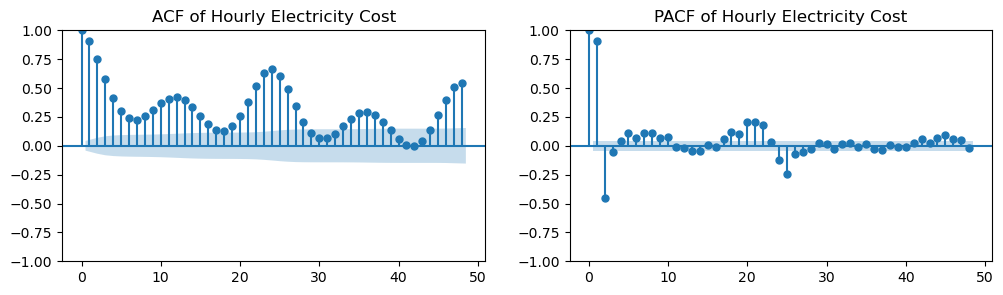

In [10]:
plt.figure(figsize=(12, 3))
plt.subplot(121)
plot_acf(df['ckwh'], lags = 48, ax = plt.gca(), title="ACF of Hourly Electricity Cost")
plt.subplot(122)
plot_pacf(df['ckwh'], lags = 48, ax = plt.gca(), title="PACF of Hourly Electricity Cost")
plt.show();

#### ARIMA

In [11]:
# Set last 7 days = 168 hours as testing set
train = df.iloc[:-168]
test = df.iloc[-168:]

In [12]:
# Fit
model = ARIMA(train['ckwh']
                , order = (1, 0, 1)
                , exog = train['dow']
               )

arima_model = model.fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ckwh   No. Observations:                 1992
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2865.931
Date:                Wed, 11 Dec 2024   AIC                           5741.863
Time:                        00:39:31   BIC                           5769.847
Sample:                    01-01-2024   HQIC                          5752.140
                         - 03-23-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6567      0.233     32.858      0.000       7.200       8.113
dow           -0.2890      0.232     -1.244      0.214      -0.744       0.166
ar.L1          0.8547      0.010     82.648      0.000       0.834       0.875
ma.L1          0.3960      0.015     25.793      0.000       0.366       0.426
sigma2         1.0393      0.020     53.282      0.000       1.001       1.078
===================================================================================
Ljung-Box (L1) (Q):                  11.43   Jarque-Bera (JB):              1517.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.40
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

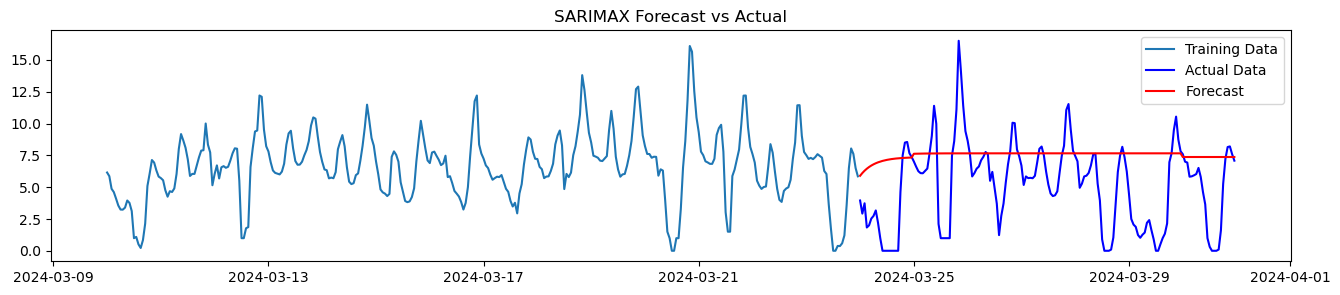

In [13]:
# Forecast
forecast = arima_model.get_forecast(steps = 168, exog = test['dow'])

# Plot Forecast vs Actual
plt.figure(figsize=(16, 3))
plt.plot(train['ckwh'][-336:], label = 'Training Data')
plt.plot(test['ckwh'], label = 'Actual Data', color = 'blue')
plt.plot(forecast.predicted_mean, label = 'Forecast', color = 'red')
plt.legend()
plt.title("SARIMAX Forecast vs Actual")
plt.show();

In [14]:
rmse = mean_squared_error(y_true = test['ckwh'], y_pred = forecast.predicted_mean, squared = False)
print("RMSE:", rmse.round(2))

RMSE: 4.04


#### SARIMAX
- **Seasonality:** The model uses a seasonality period of 24.
- **Autocorrelations:** The model captures the main autocorrelations, with significant coefficients for both non-seasonal (`AR(1), MA(1)`) and seasonal (`AR(24), MA(24)`) terms.
- **Normality of Residuals:** The **Jarque-Bera test** shows that the residuals are not normally distributed, with a p-value of 0.00. This is a common issue in time series modeling but could affect the accuracy the forecasts.
- **Heteroskedasticity:** The residuals exhibit signs of **heteroskedasticity**, indicating that the variance of the residuals is not constant over time, which may affect the model's performance.
- The root mean squared error is 2.36.

In [15]:
# Set last 7 days = 168 hours as testing set
train = df.iloc[:-168]
test = df.iloc[-168:]

In [16]:
# Fit
model = SARIMAX(train['ckwh']
                , order = (1, 0, 1)
                , seasonal_order = (1, 0, 1, 24)
                , exog = train[['dow']]
               )

sarimax_model = model.fit(disp = True)
sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               ckwh   No. Observations:                 1992
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood               -2445.177
Date:                            Wed, 11 Dec 2024   AIC                           4902.354
Time:                                    00:40:17   BIC                           4935.935
Sample:                                01-01-2024   HQIC                          4914.687
                                     - 03-23-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dow           -0.2429      0.163     -1.487      0.137      -0.563       0.077
ar.L1          0.9040      0.009    104.708      0.000       0.887       0.921
ma.L1          0.1145      0.016      7.168      0.000       0.083       0.146
ar.S.L24       0.9944      0.002    645.061      0.000       0.991       0.997
ma.S.L24      -0.8723      0.010    -90.106      0.000      -0.891      -0.853
sigma2         0.6660      0.012     55.484      0.000       0.642       0.689
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              2847.82
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

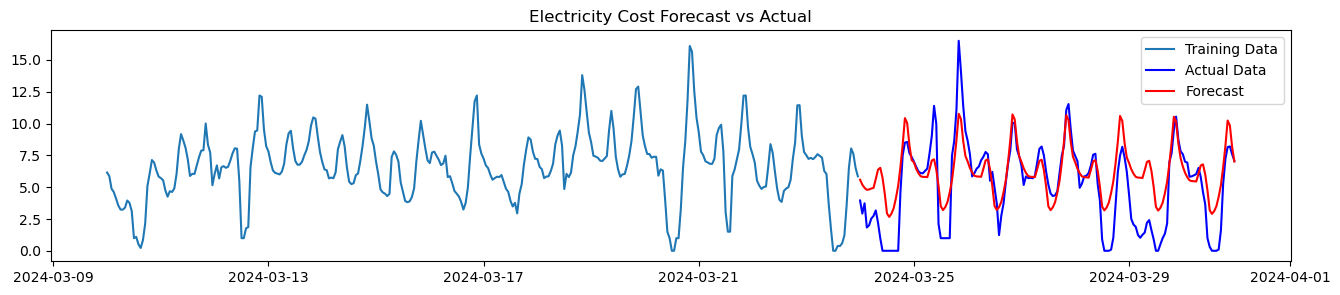

In [17]:
# Forecast
forecast = sarimax_model.get_forecast(steps = 168, exog = test[['dow']])

# Plot Forecast vs Actual
plt.figure(figsize=(16, 3))
plt.plot(train['ckwh'][-336:], label = 'Training Data')
plt.plot(test['ckwh'], label = 'Actual Data', color = 'blue')
plt.plot(forecast.predicted_mean, label = 'Forecast', color = 'red')
plt.legend()
plt.title('Electricity Cost Forecast vs Actual')
plt.show();

In [18]:
# RMSE
rmse = mean_squared_error(y_true = test['ckwh'], y_pred = forecast.predicted_mean, squared = False)
print("RMSE:", rmse.round(2))

RMSE: 2.36


#### SARIMAX with Log Transform
- By applying a log transformation, the **heteroskedasticity** is reduced, resulting in a more consistent variance of the residuals.
- The root mean squared error is 2.22.

In [19]:
df['log_ckwh'] = np.log(df['ckwh'] + 1)

In [20]:
# Set last 7 days = 168 hours as testing set
train = df.iloc[:-168]
test = df.iloc[-168:]

In [21]:
# Fit
model = SARIMAX(train['log_ckwh']
                , order = (1, 0, 1)
                , seasonal_order = (1, 0, 1, 24)
                , exog = train[['dow']]
               )

sarimax_model = model.fit(disp = True)
sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           log_ckwh   No. Observations:                 1992
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood                1165.614
Date:                            Wed, 11 Dec 2024   AIC                          -2319.229
Time:                                    00:41:17   BIC                          -2285.648
Sample:                                01-01-2024   HQIC                         -2306.896
                                     - 03-23-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dow           -0.0164      0.036     -0.459      0.646      -0.087       0.054
ar.L1          0.9200      0.006    153.458      0.000       0.908       0.932
ma.L1          0.1764      0.014     12.944      0.000       0.150       0.203
ar.S.L24       0.9960      0.001   1162.473      0.000       0.994       0.998
ma.S.L24      -0.8923      0.011    -83.212      0.000      -0.913      -0.871
sigma2         0.0177      0.000     80.081      0.000       0.017       0.018
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):             14098.67
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.36
Prob(H) (two-sided):                  0.15   Kurtosis:                        16.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

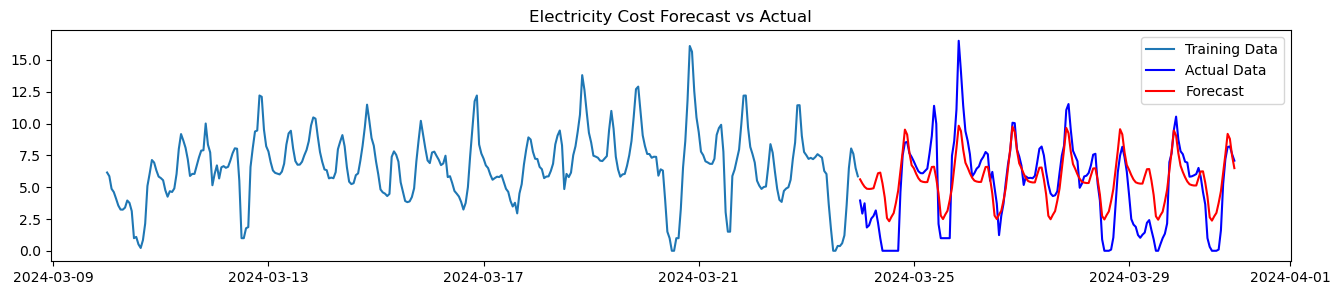

In [22]:
# Forecast
forecast = sarimax_model.get_forecast(steps = 168, exog = test[['dow']])

# Plot Forecast vs Actual
plt.figure(figsize=(16, 3))
plt.plot(train['ckwh'][-336:], label = 'Training Data')
plt.plot(test['ckwh'], label = 'Actual Data', color = 'blue')
plt.plot(np.exp(forecast.predicted_mean) - 1, label = 'Forecast', color = 'red')
plt.legend()
plt.title('Electricity Cost Forecast vs Actual')
plt.show();

In [23]:
# RMSE
rmse = mean_squared_error(y_true = test['ckwh'], y_pred = np.exp(forecast.predicted_mean) - 1, squared = False)
print("RMSE:", rmse.round(2))

RMSE: 2.22


In [24]:
# Save the best model
best_model = sarimax_model
filename = '../model/electricity_cost_sarimax_model.pkl'

with open(filename, 'wb') as file:
    pickle.dump(best_model, file)
    
print(f'Model saved to {filename}')

Model saved to ../model/electricity_cost_sarimax_model.pkl
